# Part 1: Data cleaning and preliminary EDA

Welcome to my data analysis (EDA) project! In this project, we will be analyzing the "Beer Reviews" dataset from Kaggle, uploaded by user "Datadoume". Our ultimate goal will be the construction of a beer recommendation This dataset contains data from ~1.5 million beer reviews from the website "Beer Advocate". 

In [41]:
%%capture
import scipy as sp
import kagglehub
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

In [42]:
# Download latest version
path = kagglehub.dataset_download("rdoume/beerreviews", path='beer_reviews.csv', force_download = True)

beer = pd.read_csv(path)

100%|██████████| 27.4M/27.4M [00:05<00:00, 5.55MB/s]


Let's take a quick look at our data.

In [43]:
beer.head()

,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
0,10325,Vecchio Birraio,1234817823,1.5,2.0,2.5,stcules,Hefeweizen,1.5,1.5,Sausa Weizen,5.0,47986
1,10325,Vecchio Birraio,1235915097,3.0,2.5,3.0,stcules,English Strong Ale,3.0,3.0,Red Moon,6.2,48213
2,10325,Vecchio Birraio,1235916604,3.0,2.5,3.0,stcules,Foreign / Export Stout,3.0,3.0,Black Horse Black Beer,6.5,48215
3,10325,Vecchio Birraio,1234725145,3.0,3.0,3.5,stcules,German Pilsener,2.5,3.0,Sausa Pils,5.0,47969
4,1075,Caldera Brewing Company,1293735206,4.0,4.5,4.0,johnmichaelsen,American Double / Imperial IPA,4.0,4.5,Cauldron DIPA,7.7,64883


We can see that each row represents a review ranking a beer on several qualities including an overall score. We also have some basic information about each beer reviewed, such as its type and the brewery producing the beer. Finally, we have some metadata: the date the review was posted, the username of the the user who posted the review, and unique identifiers for the breweries/beers. For the purposes of our analysis, we'll keep all the columns since they could all be useful.

Now let's see how many rows have missing values.

In [44]:
#sum rows with one or more null values
beer.isna().sum()

brewery_id                0
brewery_name             15
review_time               0
review_overall            0
review_aroma              0
review_appearance         0
review_profilename      348
beer_style                0
review_palate             0
review_taste              0
beer_name                 0
beer_abv              67785
beer_beerid               0
dtype: int64

We can see from the above output that around 68000 rows have one or more null values and most of the missing values are the ABV (alcohol by volume). Since the number of rows with null values is low compared to the size of the  data set, in this case, we'll opt to discard the null values (we are going to use ABV in our analysis).

In [45]:
#remove nulls
beer = beer[-beer.isna().any(axis=1)]

We'll also look for duplicates in the data.

In [46]:
beer.duplicated().sum()

np.int64(0)

Looks like we're good; no duplicates. At this point, we're ready to begin doing some preliminary analysis of the data. Let's take a look at the review scores first.

In [47]:
#subset data
cols = ["review_overall", "review_aroma", "review_appearance",
        "review_palate", "review_taste"]
round(beer[cols].describe(), 2)

,review_overall,review_aroma,review_appearance,review_palate,review_taste
count,1518478.00,1518478.00,1518478.00,1518478.00,1518478.00
mean,3.82,3.75,3.85,3.75,3.80
std,0.72,0.70,0.61,0.68,0.73
min,0.00,1.00,0.00,1.00,1.00
25%,3.50,3.50,3.50,3.50,3.50
50%,4.00,4.00,4.00,4.00,4.00
75%,4.50,4.00,4.00,4.00,4.50
max,5.00,5.00,5.00,5.00,5.00


/var/folders/b6/811_kpyj6yd5q_vzydsq8cbc0000gn/T/ipykernel_71752/3967134386.py:21: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


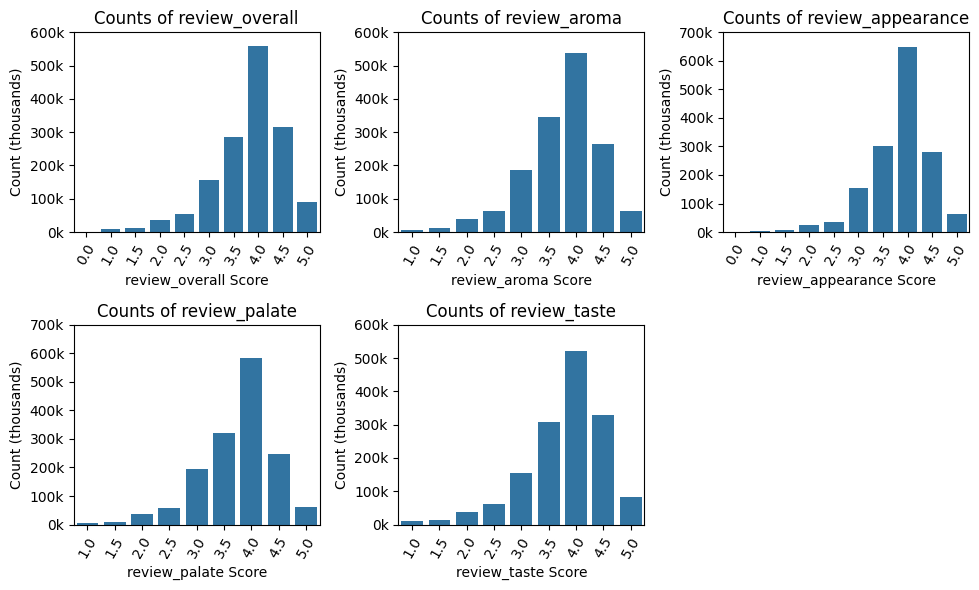

In [48]:
#create a subplots figure + axes
fig, axes = plt.subplots(2,3, figsize=(10,6))
#makes axes 1D
axes = axes.flatten()
#loop over axes and plot
for i in range(5):
        ax = axes[i]
        key = cols[i]
        sb.countplot(data=beer, x=cols[i], ax=ax)
        ax.tick_params(axis='x', rotation=60)
        ax.set_title(f'Counts of {key}')
        yticks = ax.get_yticks()
        ylabels = [f'{int(tick/1000)}k' for tick in yticks]
        ax.set_yticks(yticks)
        ax.set_yticklabels(ylabels)
        ax.set_ylabel('Count (thousands)')
        ax.set_xlabel(f'{key} Score')
#show results
fig.tight_layout()
fig.delaxes(axes[5])
fig.show()

We can see from the above results that the distribution for each score is similar - 4.0 is the most common score, with scores of 5.0 or 2.5 and below being quite uncommon. All the score distributions exhibit left skew. Let's look at ABV now.

In [49]:
#perform basic analysis at ABV data
round(beer['beer_abv'].describe(), 2)

count    1518478.00
mean           7.04
std            2.32
min            0.01
25%            5.20
50%            6.50
75%            8.50
max           57.70
Name: beer_abv, dtype: float64

We can see that there is a large range between the maximum and minimum values. Let's take a closer look at what a "typical" ABV value looks like.

In [50]:
quants = beer['beer_abv'].quantile([.5,.95])
quants

0.50     6.5
0.95    11.0
Name: beer_abv, dtype: float64

We can see that 90% of beers have ABV values between 0.95 and 11. Let's take a look at the distribution of beers within this range.

Text(0.5, 1.0, 'ABV Counts')

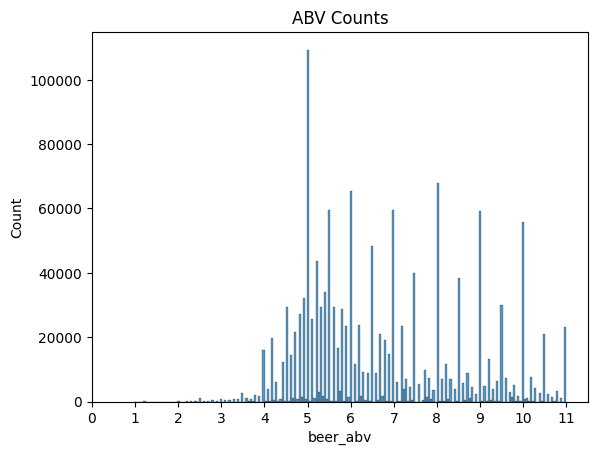

In [51]:
#let's plot the abv counts
ax = sb.histplot(data=beer, x='beer_abv', binrange=(.95,11))
ticks = list(range(12))
ax.set_xticks(ticks)
ax.set_xticklabels(ticks)
ax.set_title('ABV Counts')

It appears that beers with an ABV of 5 are the most common. It also appears that whole numbers are better represented. For fun, let's take a look at beer with the highest ABV.

In [52]:
#find most alcoholic beer
beer.loc[beer['beer_abv'] == max(beer['beer_abv'])]

,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
12919,6513,Schorschbräu,1316780901,4.0,4.0,4.0,kappldav123,Eisbock,4.0,3.5,Schorschbräu Schorschbock 57%,57.7,73368


A quick search indicates that this beer is real! Honestly, I would be very curious to try it.

At this point, we're ready to start looking into the relationships between the variables. Let's take a look at the pairwise distributions between review scores.

/var/folders/b6/811_kpyj6yd5q_vzydsq8cbc0000gn/T/ipykernel_71752/1393477205.py:23: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


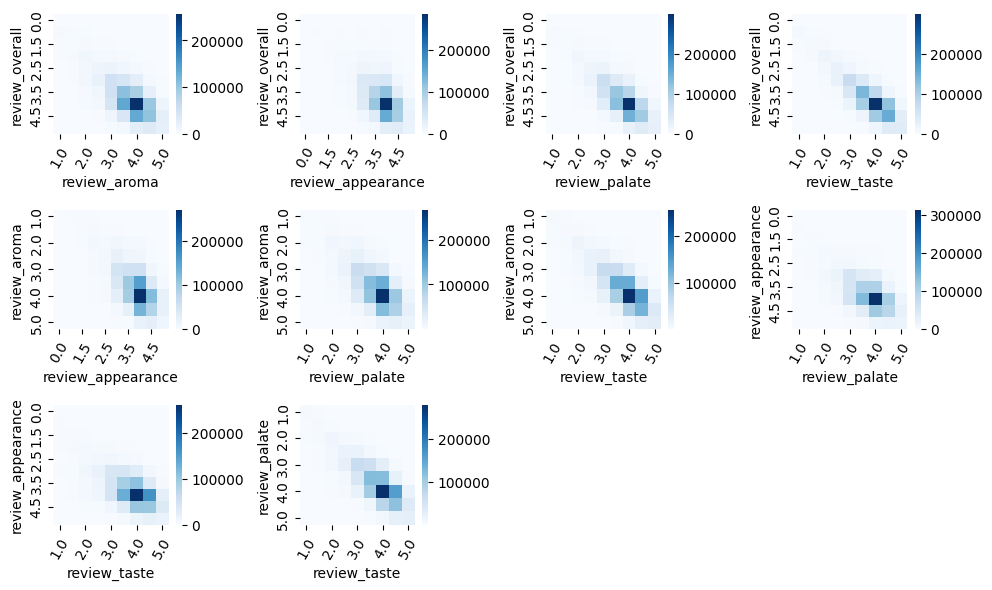

In [53]:
#generate cross-combinations for review scores
#get all pairs of raitng variables
from itertools import combinations
pairs = list(combinations(cols, 2))

#create a subplots figure + axes
fig, axes = plt.subplots(3,4, figsize=(10,6))
#makes axes 1D
axes = axes.flatten()
#loop over axes and plot
for i in range(10):
        #select correct axis
        ax = axes[i]
        #generate crosstable of variables
        cross = pd.crosstab(beer[pairs[i][0]], beer[pairs[i][1]])
        #plot pairwise heatmap
        sb.heatmap(cross, cmap='Blues', ax=ax)
        ax.tick_params(axis='x', rotation=60)
#show results
fig.tight_layout()
fig.delaxes(axes[10])
fig.delaxes(axes[11])
fig.show()

In all the pairwise distributions, the most common outcome is a score of 4 on both ratings, and in general the distributions appear similar - as we saw earlier from the univariate distribution plots, scores most commonly rnage between 3 and 4.5. We'll have to do some analysis to uncover more details about the relationships between the variables.

Let's begin by taking a correlation measure between the score variables. We shouldn't use the Pearson correlation, since it's only valid for continuous and normally distributed data with a linear relationship. Our review score variables are ordinal, so instead, we can use Spearman rank correlation and Kendall's Tau correlation.

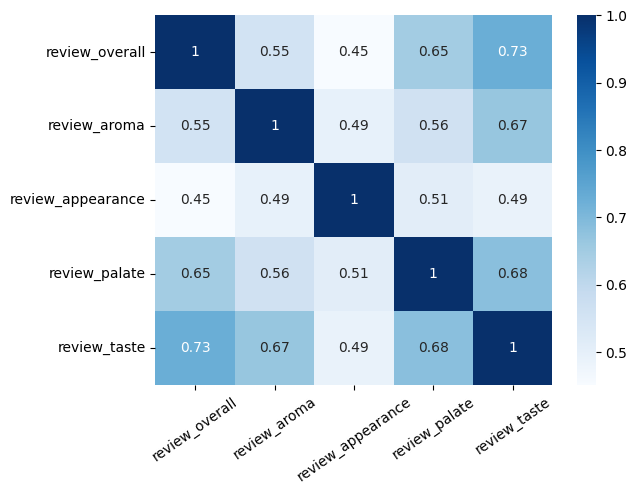

In [54]:
#get spearman correlation matrix for review scores and plot
corr = sb.heatmap(beer[cols].corr(method='spearman'), cmap='Blues', annot=True)
corr.tick_params(axis = 'x', rotation=35)

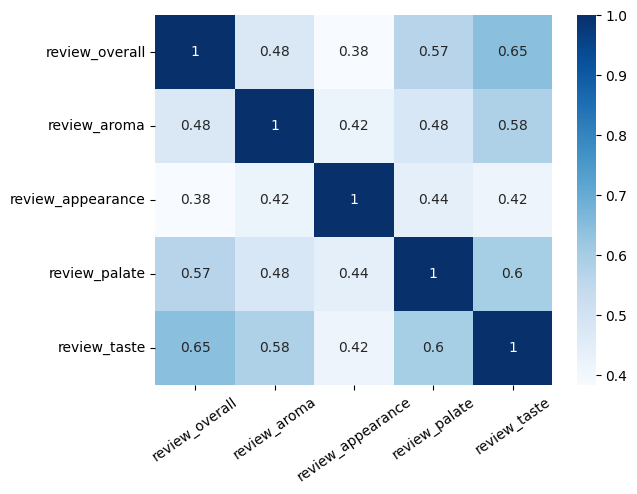

In [55]:
#get kendall correlation matrix for review scores and plot
corr = sb.heatmap(beer[cols].corr(method='kendall'), cmap='Blues', annot=True)
corr.tick_params(axis = 'x', rotation=35)

When comparing two review score variables $x,y$, we say a pair of data points $\{(x_i, y_i), (x_j,y_j)\}$ is *tied* if and only if $x_i = x_j$ or $y_i = y_j$. One feature of our data is that when calculating Pearson or Tau correlations, there will be many pairs. This is because the scores can only be chosen between $0$ and $5$ at intervals of $0.5$, with scores of 4.0 being common for all variables. For example, there are likely to be many ties where $(x_i,y_i) = (x_j,y_j) = (4.0,4.0)$. Let's get some pairwise counts of such ties, just for fun.

In [56]:
#calculate proportion of pairwise data points where review scores are both 4.0
for i in range(10):
    pair = pairs[i]
    print(pair)
    print(
        #get number of rows where scores equal 4.0 and divide by overall length
        round(beer[(beer[pair[0]] == 4.0) & (beer[pair[1]] == 4.0)].shape[0]
              /beer.shape[0],2))

('review_overall', 'review_aroma')
0.17
('review_overall', 'review_appearance')
0.19
('review_overall', 'review_palate')
0.2
('review_overall', 'review_taste')
0.2
('review_aroma', 'review_appearance')
0.18
('review_aroma', 'review_palate')
0.18
('review_aroma', 'review_taste')
0.17
('review_appearance', 'review_palate')
0.21
('review_appearance', 'review_taste')
0.17
('review_palate', 'review_taste')
0.18


As expected, we have a significant amount of ties. It's unsurprising, then, that the Kendall's Tau-b correlation values are smaller than the Spearman rho values, since the rho values can be inflated in the presence of many ties. Otherwise, the two correlation measures correspond closely in terms of the the relative pairwise magnitudes. Perhaps unsurprisingly, both correlation measures indicate the strongest relationship is between taste and overall score, and the weakest relationship is between appearance and overall score. After all, when we drink a glass of beer, we care more about how it tastes than how it looks.

# Part 2: Pouring over the dataset
Now that we've performed some basic analysis on our data, we're ready to move to some more detailed/targeted EDA. In this phase, we'd really like to investigate the data to  Let's start by finding out some basic information about user reviewing habits.

In [72]:
#We're going to load duckdb in order to run SQL queries on our data set
import duckdb as db
#let's group by user and get the average review score
#SQL query for getting the average review score and number of reviews
query = "SELECT review_profilename, AVG(review_overall) avg_score, \
    COUNT(*) num_reviews FROM beer \
    GROUP BY review_profilename ORDER BY review_profilename"
#use duckdb to query the data
userScores = db.sql(query).df()
#let's see the proportion of users with 1 review
query = "SELECT ((SELECT COUNT(*) FROM userScores WHERE num_reviews = 1) \
    / COUNT(*)) one_review_proportion FROM userScores"
db.sql(query)


┌───────────────────────┐
│ one_review_proportion │
│        double         │
├───────────────────────┤
│     0.312082168469673 │
└───────────────────────┘

Almost 30% of users have only made one review! It appears that we are not safe from the infamous "cold start" problem. Unfortunately, it will be outside the scope of our project to develop cold start mitigation strategies. We will instead focus on users and beers with multiple reviews so we can make meaningful recommendations with the limited information we have. Cold start mitigation strategies will be discussed in the project write-up. Now, let's have a closer look at the distribution of review counts.